Für die bessere Überischt importieren wir alles an einem Ort. Wir verwenden hier Keras V3, was theoretisch mit mehreren backend funktionieren könnte. Bei uns gab es aber Probleme bei dem Trainieren der Modelle mit Torch. Deshalb verwenden wir Tensorflow, leider ohne GPU Support auf Windows

In [51]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers
from livelossplot import PlotLossesKeras
from matplotlib import pyplot as plt
from tensorflow import data as tf_data

IMAGE_SIZE = (64, 64)
INPUT_SHAPE = (64, 64, 3)
BATCH_SIZE = 64

Mit der Funktion `image_dataset_from_directory` können wir die Bilddaten von der Festplatte laden. Dabei müssen sie in einem bestimmten Format sein. Ein Image Ordner mit jeweils einem Ordner für jede Klasse. Hier werden auch direkt die Batches erstellt, die Bilder gepadded auf eine gemeinsame Grösse und ein Validation/Trian Split erstellt.

In [52]:
data_dir = os.path.join("data", "images")
entries = os.listdir(data_dir)
folder_count = sum(os.path.isdir(os.path.join(data_dir, entry)) for entry in entries)

train_ds, val_ds = keras.utils.image_dataset_from_directory(
        os.path.join("data", "images"),
        labels="inferred",
        label_mode="binary" if folder_count == 2 else "categorical",
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=IMAGE_SIZE,
        shuffle=True,
        interpolation="bilinear",
        pad_to_aspect_ratio=True,
        validation_split=0.2,
        subset="both",
        seed=42,
    )

if len(train_ds.class_names) == 2:
    NUMBER_OF_CLASSES = 1
else:
    NUMBER_OF_CLASSES = len(train_ds.class_names)

Found 16000 files belonging to 2 classes.
Using 12800 files for training.
Using 3200 files for validation.


Data Augmentation sollte theoretisch dabei helfen die Klassifikation besser zu machen, indem die Daten variiert werden. Wir drehen sie und verändern den Kontrast und die Helligkeit. Zusätzlich werden die Daten normalisiert. 

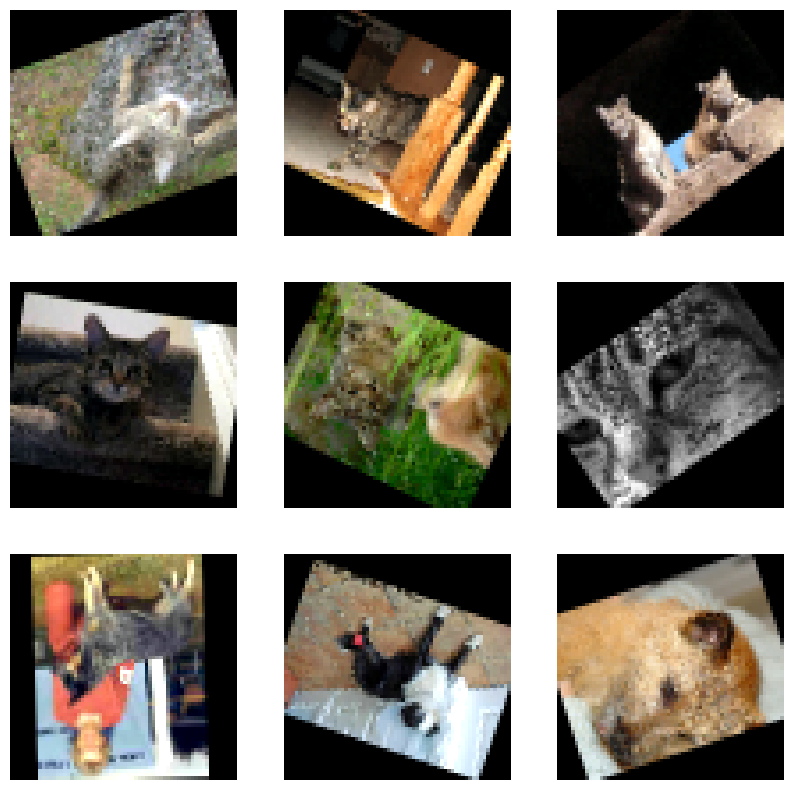

In [53]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1, fill_mode="constant", interpolation="bilinear"),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),
    layers.Rescaling(1./255)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

augmented_train_ds = train_ds.map(
    lambda images, labels: (data_augmentation(images), labels),
    num_parallel_calls=tf_data.AUTOTUNE)

augmented_val_ds = val_ds.map(
    lambda images, labels: (data_augmentation(images), labels),
    num_parallel_calls=tf_data.AUTOTUNE)

plt.figure(figsize=(10, 10))
for batch_images, _ in augmented_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(keras.utils.array_to_img(batch_images[i]))
        plt.axis("off")

Die Daten vorab in das Memory zu laden ist theoretisch schneller, deshalb machen wir es

In [54]:
augmented_train_ds = augmented_train_ds.prefetch(tf_data.AUTOTUNE)
augmented_val_ds = augmented_val_ds.prefetch(tf_data.AUTOTUNE)

Dann bauen wir ein einfaches CNN. Durch Keras util Funktionen können wir zusätzlich das Modell graphisch anzeigen lassen.

In [55]:
model = keras.Sequential([
    layers.InputLayer(shape=INPUT_SHAPE),
    
    layers.Conv2D(32, kernel_size=(4, 4), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    layers.BatchNormalization(),
    layers.Activation("relu"),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(NUMBER_OF_CLASSES, activation=None),
])

if NUMBER_OF_CLASSES == 1:
    model.compile(
        optimizer=keras.optimizers.Adam(0.005),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )
else:
    model.compile(
        optimizer=keras.optimizers.Adam(0.005),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy(name="acc")],
    )

model.summary()
# keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 61, 61, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,561 (369.38 KB)

 Trainable params: 94,305 (368.38 KB)

 Non-trainable params: 256 (1.00 KB)

Training mit Live-Plots

In [57]:
early_stop_cb = keras.callbacks.EarlyStopping(min_delta=0.01, patience=4, restore_best_weights=True, monitor="val_acc", mode="max")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[PlotLossesKeras(), early_stop_cb],
)

Accuracy
	training         	 (min:    0.616, max:    0.795, cur:    0.795)
	validation       	 (min:    0.541, max:    0.735, cur:    0.711)
Loss
	training         	 (min:    0.413, max:    0.625, cur:    0.413)
	validation       	 (min:    0.534, max:    0.776, cur:    0.534)
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - acc: 0.7953 - loss: 0.4183 - val_acc: 0.7109 - val_loss: 0.5335
